# Light Beads Microscopy Demo Pipeline 

## Overview
### Pre-Processing:
- Extract ScanImage metadata
- Correct Bi-Directional Offset for each ROI
- Calculates and corrects the MROI seams (IN PROGRESS)
### Motion Correction
- Apply the nonrigid motion correction (NoRMCorre) algorithm for motion correction.
- View pre/most correction movie
- Use quality metrics to evaluate registration quality
### Segmentation
- Apply the constrained nonnegative matrix factorization (CNMF) source separation algorithm to extract initial estimates of neuronal spatial footprints and calcium traces.
- Apply quality control metrics to evaluate the initial estimates, and narrow down to the final set of estimates.

### Setup
- Import necessary libraries
Notable: Numpy, Cv2, Zarr, Dask, Matplotlib

/v-data4/foconnell/code/rbo-lbm/demos/notebooks


2024-05-09 11:08:28.330673: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 11:08:28.330706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 11:08:28.331737: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
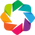

In [1]:
import os
import sys
import time
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import psutil

# Give this notebook access to the root package
sys.path.append('../../')  # TODO: Take this out when we upload to pypi
print(sys.path[0])

import core.io
import scanreader

import zarr
try:
    import dask.array as da
except:
    %pip install dask
    import dask.array as da
import bokeh.plotting as bpl
import holoviews as hv
import panel as pn
from IPython import get_ipython
import logging
import matplotlib.pyplot as plt

try:
    cv2.setNumThreads(0)
except():
    pass

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

bpl.output_notebook()
hv.notebook_extension('bokeh', 'matplotlib')

# logging
logging.basicConfig(format="{asctime} - {levelname} - [{filename} {funcName}() {lineno}] - pid {process} - {message}",
                    filename=None, 
                    level=logging.WARNING, style="{") # this shows you just errors that can harm your program
                    # level=logging.DEBUG, style="{") # this shows you general information that developers use to trakc their program 
                    # (be careful when playing movies, there will be a lot of debug messages)

# set env variables 
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

#### Set up a few helper functions for plotting, logging and setting up our environment

In [2]:
chan_order = np.array([ 1, 5, 6, 7, 8, 9, 2, 10, 11, 12, 13, 14, 15, 16, 17, 3, 18, 19, 20, 21, 22, 23, 4, 24, 25, 26, 27, 28, 29, 30])  # this is specific to our dataset
chan_order = [x-1 for x in chan_order]  # convert to 0-based indexing

## Extract data using scanreader, joining contiguous ROI's, and plot our mean image

Our ScanReader object contains all of the properties needed to keep track of our raw data. 
- ScanImage metadata is stored alongside header metadata, this ScanImage specific data is what's needed to assemble frames from constituent ROIs.
- We calculate the frame rate and time/pixels between scans and ROI's using the following metadata:

![frame rate calculation](../../docs/img/FrameRate1eq.png)


#### Joining Contiguious ROI's

Setting `join_contiguous=True` will combine ROI's with the following constraints:

1) Must be the same size/shape
2) Must be located in the same scanning depth
3) Must be located in the same slice
- ROI can be directly left, right, above or below the adjacent ROI's

In [20]:
overwrite = False # flag to re-extract tiffs with extracted data

datapath = Path('/data2/fpo/data')                 # string pointing to directory containing your data
savepath = Path('/data2/fpo/data/temp/')                 # string pointing to directory containing your data
savepath.mkdir(exist_ok=True, parents=True)
htiffs = [x for x in datapath.glob('*.tif')]         # this accumulates a list of every filepath which contains a .tif file
reader = scanreader.read_scan(str(htiffs[0]), join_contiguous=True, lbm=True, x_cut=(5,5))  # this should take < 2s, no actual data is being read yet

for i in range(1, 10):
    # check for the existence of this file before any data is read
    save_str = savepath / f'xcut_{i}.zarr'
    if not overwrite and save_str.exists:
        continue
    data = reader[0]  # here we actually read the .tiff pages
    store = zarr.DirectoryStore(save_str)  # save data to persistent disk storage
    z = zarr.zeros(data.shape, chunks=(data.shape[0], data.shape[1], 1, data.shape[3]), dtype='int16', store=store, overwrite=overwrite)
    z[:] = data             # this will auto-chunk based on the specified chunks in 'open'

In [24]:
digits = [int(x.stem.split('_')[-1]) for x in Path(savepath).glob('*.zarr')]
images = {}
for i in digits:
    arr = zarr.open(str(savepath / f'xcut_{i}.zarr'), mode='r')
    images[i] = hv.Image(arr[:,:,5,400]).opts(
        width=600,
        height=600,
        title=f"pixels_cut: {i}",
        tools=['wheel_zoom'],
        cmap='gray', 
        )

In [26]:
def get_plot(i):
    return images[i]

# Widgets
image_widget = pn.widgets.IntSlider(name="Image_widget_1", value=1, start=1, end=9)
bound_plot = pn.bind(get_plot, i=image_widget) 

# Layout of widgets and plot
layout = pn.Column(
    pn.Row(image_widget, sizing_mode="fixed", width=300),
    bound_plot
)

# Display the layout
layout.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'8b5eaccd-2c8d-4e40-aed1-18868ab1fa38': {'version…

UnknownReferenceError: can't resolve reference 'p2342'

UnknownReferenceError: can't resolve reference 'p2342'

UnknownReferenceError: can't resolve reference 'p2342'

UnknownReferenceError: can't resolve reference 'p2342'

In [16]:
pn.template.MaterialTemplate(
    site="Panel",
    title="Getting Started App",
    sidebar=[image_widget_1, image_widget_2],
    main=[bound_plot],
).servable(); 

In [287]:
# iterate over each tiff page to collect offsets. 40s for [300x300x30x1700] dtype=int16
data = reader[0]
print(f'Data shape: {data.shape} \nData type: {data.dtype}')

### Data Storage: Zarr

[Zarr documentation](https://zarr.readthedocs.io/en/stable/tutorial.html)

Deciding how to save data on a host operating system is *far* from straight foreward. Read/write operations will vary widely between data saved in a **single file**
structure vs smaller chunks, e.g. one image per file, one image per epoch, etc. 
 
The former strategy is clean/consice and easy to handle but is *not* feasable with large (>10GB) datasets. 

The latter strategy of spreading files acrossed nested groups of directories, each with their own metadata/attributes has been widely adopted as the more sensible approach. HDF5 has 
been the frontrunner in scientific data I/O but suffers from widely inconsistent within academia.  

- Zarr, similar to H5, is a heirarchical data storage specification (or in non-alien speak: "rules of how data is stored on disk").
- Zarr nicely hides the complexities inherent in linking filesystem heirarchy with efficient data I/O.

#### The below section demonstrates how to search for the `optimal` data chunking/partitioning scheme for our datasets


In [290]:
def process_dataset(data, dataset_name, chunk_shape, savepath=''):
    savepath = Path(savepath).with_suffix('.zarr')
    if not savepath.exists():
        print(f"{savepath} doesn't exist, creating...")
        savepath.parent.mkdir(parents=True, exist_ok=True)

    # benchmark write
    start = time.time()
    store = zarr.DirectoryStore(savepath)  # save data to persistent disk storage
    z = zarr.zeros(data.shape, chunks=chunk_shape, dtype='int16', store=store, overwrite=True)

    z[:] = data             # this will auto-chunk based on the specified chunks in 'open'
    # z = data              # equivalent 
    # z[:, :, :, :] = data  # equivalent

    write = time.time() - start
    formatted_write = f"{write:.2f}"

    # benchmark read
    start = time.time()
    _ = z[:]
    read = time.time() - start
    formatted_read = f"{read:.2f}"

    chunksize_nbytes = np.prod(chunk_shape) * z.dtype.itemsize  # 2 bytes per int16
    return [
        str(data.shape),
        str(z.chunks),
        z.nbytes / 1e6,
        chunksize_nbytes / 1e6,
        z.dtype,
        z.order,
        formatted_read,
        formatted_write,
        z.store.path
    ]

### Save our raw data to a zarr store

Zarr allows us to maintain persistent storage, that is, save chunks of our data to disk without needing to hold it in memory.

- `zarr.open` is a convenience method that handles chunking and compression for persistant storage.
- We want to keep this data as `16 bit` integers because no calculations should be done yet.

In general, we want this value to be `~1Mb` to optimize write speed. 

```python
name = '/path/to/folder'
chunksize=[300,,30]
z1 = zarr.open(f'{name}', mode='w', shape=(data.shape),chunks=chunksize, dtype='int16')
```

In [291]:
labels = [
    'Array  [x,y,z,t]',
    'Chunks [x,y,z,t]',
    'Array Size (Mb)',
    'Chunk Size (Mb)',
    'Data Type',
    'Order',
    'Read Time (s)',
    'Write Time (s)',
    'Save Path'
]

# the chunk sizes we want to benchmark
chunksizes = [
    (data.shape[0], data.shape[1], 1, data.shape[3]),  # [300x300x1x1750]
    (data.shape[0], data.shape[1], data.shape[2], 1),  # [300x300x30x1  ]
    (data.shape[0], data.shape[1], 1, 1)               # [300x300x1x1   ]
]

# give our dataset a name. this will be the column header
names = [
    ('chunked_by_plane'),  # [300x300x1x1750]
    ('chunked_by_frame'),  # [300x300x30x1  ]
    ('chunked_by_image')   # [300x300x1x1   ]
]

vals = {data_name: [] for data_name in names}
for i, (chunksize, dataset) in enumerate(zip(chunksizes, names)):
    # save the same data but with different chunk sizes
    vals[dataset] = process_dataset(data, dataset, chunksize, savepath=f"/data2/fpo/data/zarr/{dataset}")

df = pd.DataFrame(index=labels, columns=names, data=None)
for k, v in vals.items():
    df[k] = v
df


## Inspect raw vs extracted zarr data 
Visual inspection to verify the chosen compression didn't lead to any artifacts

In [297]:
images = []
image_raw = hv.Image(data[:, :, 5, 400]).opts(
        width=600,
        height=600,
        title="Raw Image",
        tools=['wheel_zoom'],
        cmap='gray', 
        )
for dname in df.columns:
    zpath = df.loc['Save Path', dname]
    arr = zarr.open(zpath, mode='r')
    images.append(hv.Image(arr[:,:,5,400]).opts(
        width=600,
        height=600,
        title=dname,
        tools=['wheel_zoom'],
        cmap='gray', 
        )
    )

# layout =image_raw+ images[0] + images[1] + images[2]
bpl.show(hv.render(image_raw))

## Scan Phase Correction




### *Methods:*

**1) Linear interpolation**

**2) Phase - cross correlation**


### Phase correction via Linear Phase Interpolation 

In [45]:

xd = da.from_array(z1, chunks=z1.chunks)
xd

In [ ]:
phase_angle = core.util.compute_raster_phase(xd[:,:, 5, 400], reader.temporal_fill_fraction)
corrected_li = core.util.correct_raster(xd, phase_angle, reader.temporal_fill_fraction)
phase_angle

In [33]:
corr = core.util.return_scan_offset(slice_plane[:,:,400], 1)
corrected_pc = core.util.fix_scan_phase(z1, corr, 1)

## Motion Correction: CaImAn - NORMCorre

### Load pre-processed data as a CaImAn `movie`

In [ ]:
import caiman as cm

In [ ]:
movie = cm.movie(slice_plane, start_time=2, fr=reader.fps)
downsampling_ratio = 0.2  # subsample 5x
movie = movie.resize(fz=downsampling_ratio)
# movie.play(gain=1.3, backend='embed_opencv')

### View correlation metrics

Create a couple of summary images of the movie, including:
- maximum projection (the maximum value of each pixel) 
- correlation image (how correlated each pixel is with its neighbors)

If a pixel comes from an active neural component it will tend to be highly correlated with its neighbors.

In [ ]:
max_projection_orig = np.max(movie, axis=0)
correlation_image_orig = cm.local_correlations(movie, swap_dim=False)
correlation_image_orig[np.isnan(correlation_image_orig)] = 0 # get rid of NaNs, if they exist

In [ ]:
f, (ax_max, ax_corr) = plt.subplots(1,2)
ax_max.imshow(max_projection_orig, 
              cmap='viridis',
              vmin=np.percentile(np.ravel(max_projection_orig),50), 
              vmax=np.percentile(np.ravel(max_projection_orig),99.5));
ax_max.set_title("Max Projection Orig", fontsize=12);

ax_corr.imshow(correlation_image_orig, 
               cmap='viridis', 
               vmin=np.percentile(np.ravel(correlation_image_orig),50), 
               vmax=np.percentile(np.ravel(correlation_image_orig),99.5));
ax_corr.set_title('Correlation Image Orig', fontsize=12);

### Parameter Selection

In [ ]:
max_shifts = (6, 6)  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
strides =  (48, 48)  # create a new patch every x pixels for pw-rigid correction
overlaps = (24, 24)  # overlap between patches (size of patch strides+overlaps)
max_deviation_rigid = 3   # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = False  # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = True  # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'  # replicate values along the boundary (if True, fill in with NaN)

In [ ]:
parameter_dict = {'fnames': tiffs,
                  'fr': fr,
                  'dxy': dxy,
                  'decay_time': decay_time,
                  'strides': strides,
                  'overlaps': overlaps,
                  'max_shifts': max_shifts,
                  'max_deviation_rigid': max_deviation_rigid,
                  'pw_rigid': pw_rigid,
                  'p': p,
                  'nb': gnb,
                  'rf': rf,
                  'K': K, 
                  'gSig': gSig,
                  'gSiz': gSiz,
                  'stride': stride_cnmf,
                  'method_init': method_init,
                  'rolling_sum': True,
                  'only_init': True,
                  'ssub': ssub,
                  'tsub': tsub,
                  'merge_thr': merge_thr, 
                  'bas_nonneg': bas_nonneg,
                  'min_SNR': min_SNR,
                  'rval_thr': rval_thr,
                  'use_cnn': True,
                  'min_cnn_thr': cnn_thr,
                  'cnn_lowest': cnn_lowest}

parameters = params.CNMFParams(params_dict=parameter_dict) # CNMFParams is the parameters class
print(f"You have {psutil.cpu_count()} CPUs available in your current environment")
num_processors_to_use = None

In [59]:
#%% start the cluster (if a cluster already exists terminate it)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='multiprocessing', n_processes=None, single_thread=False)
# create a motion correction object

mc = MotionCorrect(fnames, dview=dview, max_shifts=max_shifts,
                  strides=strides, overlaps=overlaps,
                  max_deviation_rigid=max_deviation_rigid, 
                  shifts_opencv=shifts_opencv, nonneg_movie=True,
                  border_nan=border_nan)

mov=(cm.movie(mot_correct)).play(magnification=2, fr=reader.fps, q_min=0.1, q_max=99.9)

### Cleanup

Make sure our parallel cluster is shut down.

In [ ]:
cm.stop_server(dview=cluster)